In [1]:
# Enhanced Image Compression Pipeline for Jupyter Notebook
import numpy as np
import cv2
import pywt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import pickle
from skimage.metrics import structural_similarity as ssim

# ---- Arithmetic Coding Implementation ---- #
class ArithmeticEncoder:
    def __init__(self, precision=32):
        self.precision = precision
        self.full_range = 1 << precision
        self.half_range = self.full_range >> 1
        self.quarter_range = self.half_range >> 1
        self.minimum_range = self.quarter_range + 2
        self.maximum_total = self.minimum_range
        self.low = 0
        self.high = self.full_range - 1
        self.pending_bits = 0
        self.output_bits = []

    def update(self, symbol_low, symbol_high, total):
        range_ = self.high - self.low + 1
        self.high = self.low + (range_ * symbol_high // total) - 1
        self.low = self.low + (range_ * symbol_low // total)
        while True:
            if self.high < self.half_range:
                self._write_bit(0)
            elif self.low >= self.half_range:
                self._write_bit(1)
                self.low -= self.half_range
                self.high -= self.half_range
            elif self.low >= self.quarter_range and self.high < 3 * self.quarter_range:
                self.pending_bits += 1
                self.low -= self.quarter_range
                self.high -= self.quarter_range
            else:
                break
            self.low <<= 1
            self.high = (self.high << 1) + 1

    def _write_bit(self, bit):
        self.output_bits.append(bit)
        for _ in range(self.pending_bits):
            self.output_bits.append(1 - bit)
        self.pending_bits = 0

    def finish(self):
        self.pending_bits += 1
        if self.low < self.quarter_range:
            self._write_bit(0)
        else:
            self._write_bit(1)

    def get_encoded_bytes(self):
        bits = self.output_bits
        while len(bits) % 8 != 0:
            bits.append(0)
        byte_arr = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte << 1) | b
            byte_arr.append(byte)
        return bytes(byte_arr)

class ArithmeticDecoder:
    def __init__(self, encoded_data, precision=32):
        self.precision = precision
        self.full_range = 1 << precision
        self.half_range = self.full_range >> 1
        self.quarter_range = self.half_range >> 1
        self.encoded_data = encoded_data
        self.bit_index = 0
        self.low = 0
        self.high = self.full_range - 1
        self.value = 0
        
        for _ in range(precision):
            self.value = (self.value << 1) | self._read_bit()

    def _read_bit(self):
        if self.bit_index >= len(self.encoded_data) * 8:
            return 0
        byte_idx = self.bit_index // 8
        bit_idx = 7 - (self.bit_index % 8)
        bit = (self.encoded_data[byte_idx] >> bit_idx) & 1
        self.bit_index += 1
        return bit

    def decode(self, cum_freq, total, data_length):
        decoded = []
        for _ in range(data_length):
            range_ = self.high - self.low + 1
            scaled_value = ((self.value - self.low + 1) * total - 1) // range_

            symbol = 0
            for s in range(256):
                if cum_freq.get(s+1, total) > scaled_value:
                    symbol = s
                    break
            if symbol == 256:
                break
            decoded.append(symbol)
            symbol_low = cum_freq[symbol]
            symbol_high = cum_freq.get(symbol+1, total)
            self.high = self.low + (range_ * symbol_high // total) - 1
            self.low = self.low + (range_ * symbol_low // total)

            while True:
                if self.high < self.half_range:
                    pass
                elif self.low >= self.half_range:
                    self.low -= self.half_range
                    self.high -= self.half_range
                    self.value -= self.half_range
                elif self.low >= self.quarter_range and self.high < 3 * self.quarter_range:
                    self.low -= self.quarter_range
                    self.high -= self.quarter_range
                    self.value -= self.quarter_range
                else:
                    break
                self.low <<= 1
                self.high = (self.high << 1) + 1
                self.value = (self.value << 1) | self._read_bit()
        return bytes(decoded)

def build_frequency_table(data):
    freq = {}
    for byte in data:
        freq[byte] = freq.get(byte, 0) + 1
    return freq

def create_cumulative_freq(freq):
    cum_freq = {}
    total = 0
    for symbol in range(256):
        count = freq.get(symbol, 0)
        cum_freq[symbol] = total
        total += count
    cum_freq[256] = total
    return cum_freq, total

def arithmetic_encode(data):
    freq = build_frequency_table(data)
    freq[256] = 1
    cum_freq, total = create_cumulative_freq(freq)
    encoder = ArithmeticEncoder()
    for symbol in data:
        low = cum_freq[symbol]
        high = cum_freq[symbol] + freq[symbol]
        encoder.update(low, high, total)
    encoder.update(cum_freq[256], cum_freq[256] + freq[256], total)
    encoder.finish()
    return encoder.get_encoded_bytes(), freq, cum_freq, total

def arithmetic_decode(encoded_data, freq, cum_freq, total, data_length):
    decoder = ArithmeticDecoder(encoded_data)
    return decoder.decode(cum_freq, total, data_length)

# ---------------- Compression Pipeline Functions ---------------- #

def apply_dwt(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    cA = np.uint8(np.clip(cA, 0, 255))
    return cA

def apply_kmeans(image, k=16):
    Z = image.reshape((-1, 1)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(Z)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    clustered_image = clustered.reshape(image.shape).astype(np.uint8)
    return clustered_image

def show_image(image, title, cmap='gray'):
    plt.figure(figsize=(6, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_comparison(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def compress_and_decompress_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return None
    original_size = img.nbytes
    original_shape = img.shape
    print(f"Original image size: {original_size:,} bytes")
    print(f"Original image shape: {original_shape}")

    print("\nApplying Discrete Wavelet Transform...")
    dwt_img = apply_dwt(img)
    dwt_shape = dwt_img.shape
    dwt_bytes = dwt_img.tobytes()

    print("\nApplying K-Means clustering...")
    clustered_img = apply_kmeans(dwt_img, k=16)
    kmeans_bytes = clustered_img.tobytes()

    print("\nApplying Arithmetic Coding...")
    encoded_bytes, freq, cum_freq, total = arithmetic_encode(kmeans_bytes)

    base_name = os.path.splitext(image_path)[0]
    compressed_path = base_name + "_compressed.pkl"
    compression_data = {
        'encoded_bytes': encoded_bytes,
        'freq': freq,
        'cum_freq': cum_freq,
        'total': total,
        'data_length': len(kmeans_bytes),
        'dwt_shape': dwt_shape,
        'original_shape': original_shape
    }
    with open(compressed_path, "wb") as f:
        pickle.dump(compression_data, f)
    print(f"Compressed file saved to: {compressed_path}")

    print("\nDecompressing image...")
    decoded_bytes = arithmetic_decode(encoded_bytes, freq, cum_freq, total, len(kmeans_bytes))
    decompressed_clustered = np.frombuffer(decoded_bytes, dtype=np.uint8).reshape(dwt_shape)

    decompressed_path = base_name + "_decompressed.png"
    cv2.imwrite(decompressed_path, decompressed_clustered)
    print(f"Decompressed image saved to: {decompressed_path}")

    psnr_value = cv2.PSNR(clustered_img, decompressed_clustered)
    ssim_value = ssim(clustered_img, decompressed_clustered)
    print("\nQuality Metrics:")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")

    print("\nDisplaying compression stages...")
    show_comparison(
        [img, dwt_img, clustered_img, decompressed_clustered],
        ["Original", "After DWT", "After K-Means", "Decompressed"]
    )

    final_compression = original_size / len(encoded_bytes)
    print("\n" + "=" * 60)
    print("COMPRESSION SUMMARY:")
    print(f"Original size:     {original_size:,} bytes")
    print(f"Final size:        {len(encoded_bytes):,} bytes")
    print(f"Space saved:       {original_size - len(encoded_bytes):,} bytes")
    print(f"Compression ratio: {final_compression:.2f}:1")
    print(f"Size reduction:    {((original_size - len(encoded_bytes)) / original_size * 100):.1f}%")
    print(f"Decompressed image saved as: {decompressed_path}")

    return {
        'original_size': original_size,
        'final_size': len(encoded_bytes),
        'compression_ratio': final_compression,
        'psnr': psnr_value,
        'ssim': ssim_value,
        'original_image': img,
        'dwt_image': dwt_img,
        'clustered_image': clustered_img,
        'decompressed_image': decompressed_clustered,
        'compressed_file': compressed_path,
        'decompressed_file': decompressed_path
    }

def load_and_decompress(compressed_file_path):
    try:
        with open(compressed_file_path, "rb") as f:
            data = pickle.load(f)
        decoded_bytes = arithmetic_decode(
            data['encoded_bytes'], 
            data['freq'], 
            data['cum_freq'], 
            data['total'], 
            data['data_length']
        )
        decompressed_image = np.frombuffer(decoded_bytes, dtype=np.uint8).reshape(data['dwt_shape'])
        base_name = os.path.splitext(compressed_file_path)[0]
        output_path = base_name + "_restored.png"
        cv2.imwrite(output_path, decompressed_image)
        print(f"Image decompressed and saved to: {output_path}")
        show_image(decompressed_image, "Decompressed Image")
        return decompressed_image, output_path
    except Exception as e:
        print(f"Error loading compressed file: {e}")
        return None, None

# ---------------- Usage Examples ---------------- #
print("Enhanced Image Compression Pipeline Ready!")
print("=" * 50)
print("Usage:")
print("1. compress_and_decompress_image('your_image.jpg')")
print("2. load_and_decompress('your_image_compressed.pkl')")
print("=" * 50)

Enhanced Image Compression Pipeline Ready!
Usage:
1. compress_and_decompress_image('your_image.jpg')
2. load_and_decompress('your_image_compressed.pkl')


Original image size: 264,069 bytes
Original image shape: (481, 549)

Applying Discrete Wavelet Transform...

Applying K-Means clustering...


C:\Users\Manso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



Applying Arithmetic Coding...
Compressed file saved to: test-images/test1_compressed.pkl

Decompressing image...
Decompressed image saved to: test-images/test1_decompressed.png

Quality Metrics:
PSNR: 54.27 dB
SSIM: 1.0000

Displaying compression stages...


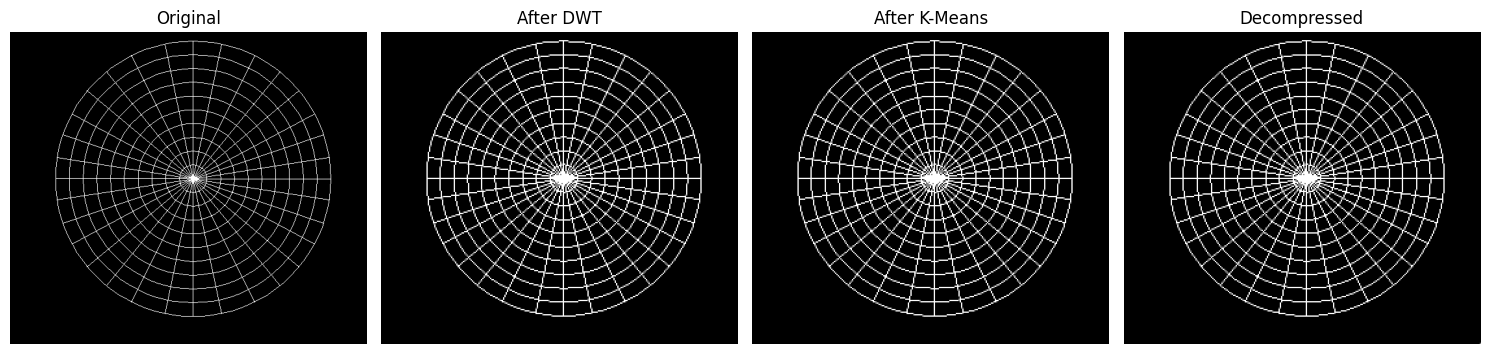


COMPRESSION SUMMARY:
Original size:     264,069 bytes
Final size:        4,842 bytes
Space saved:       259,227 bytes
Compression ratio: 54.54:1
Size reduction:    98.2%
Decompressed image saved as: test-images/test1_decompressed.png


{'original_size': 264069,
 'final_size': 4842,
 'compression_ratio': 54.537174721189594,
 'psnr': 54.26822655361127,
 'ssim': np.float64(0.9999853555099814),
 'original_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'dwt_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'clustered_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'decompressed_image': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
  

In [2]:
compress_and_decompress_image('test-images/test1.png')

Original image size: 960,000 bytes
Original image shape: (800, 1200)

Applying Discrete Wavelet Transform...

Applying K-Means clustering...

Applying Arithmetic Coding...
Compressed file saved to: test-images/test2_compressed.pkl

Decompressing image...
Decompressed image saved to: test-images/test2_decompressed.png

Quality Metrics:
PSNR: 69.06 dB
SSIM: 1.0000

Displaying compression stages...


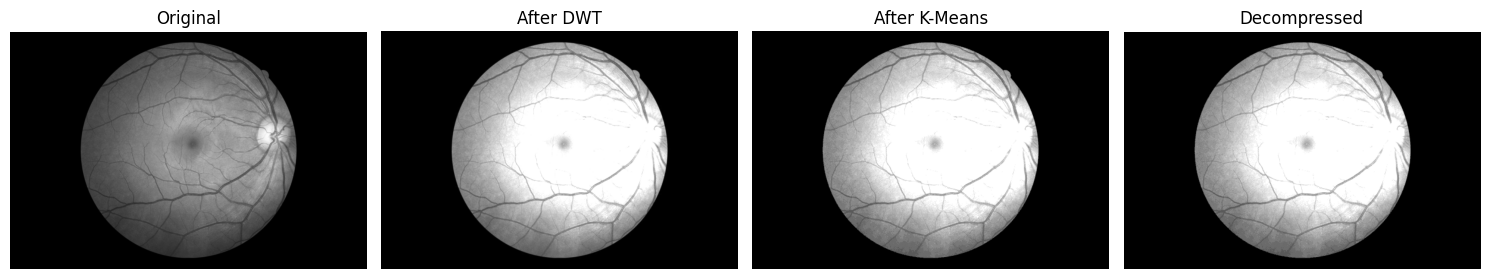


COMPRESSION SUMMARY:
Original size:     960,000 bytes
Final size:        72,417 bytes
Space saved:       887,583 bytes
Compression ratio: 13.26:1
Size reduction:    92.5%
Decompressed image saved as: test-images/test2_decompressed.png


{'original_size': 960000,
 'final_size': 72417,
 'compression_ratio': 13.256555781101122,
 'psnr': 69.0638624960714,
 'ssim': np.float64(0.9999979965041245),
 'original_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'dwt_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'clustered_image': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'decompressed_image': array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  

In [3]:
compress_and_decompress_image('test-images/test2.jpg')